# TF activity inference with decoupler
**Authorship:** Adam Klie (last updated: 08/27/2023)<br>
***
**Description:** This notebook performs a tf activity inference analysis with decoupler

# Set-up

In [1]:
# Global Imports
import os
import sys
import yaml
import logging
import scanpy as sc
import decoupler as dc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Plotting options, change to your liking
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))
sc.settings.verbosity = 3

# Local imports
sys.path.append("/cellar/users/aklie/data/igvf/bin")
from utils import make_dirs

/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py38/lib/python3.8/site-packages/loompy/bus_file.py:68: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def twobit_to_dna(twobit: int, size: int) -> str:
/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py38/lib/python3.8/site-packages/loompy/bus_file.py:85: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def 

In [2]:
# Dataset
dataset_name = "igvf_sc-islet_10X-Multiome"

# Inputs
platinum_dir = "/cellar/users/aklie/data/igvf/beta_cell_networks/platinum"
in_date = "25Aug23"
in_dir = os.path.join(platinum_dir, dataset_name, in_date, "scRNA")

# Outputs
results_dir = "/cellar/users/aklie/projects/igvf/beta_cell_networks/infer_cellular_programs/decoupler/results/igvf_sc-islet_10X-Multiome"
out_date = "25Aug23"
out_analysis = "tf_activity_inference"
out_dir = os.path.join(results_dir, out_date, out_analysis)
make_dirs(out_dir)

# Method params
annotation_resource = "dorothea"
normalize_data = True
method = "ulm"

In [63]:
# Make and log a yaml file with the parameters
data_params = {
    "dataset_name": dataset_name,
    "in_date": in_date,
    "in_dir": in_dir,
    "out_date": out_date,
    "out_analysis": out_analysis,
    "out_dir": out_dir,
}
decoupler_params = {
    "annotation_resource": annotation_resource,
    "normalize_data": normalize_data,
    "method": method,
}
version_params = {
    "Python": sys.version[:5],
    "scanpy": sc.__version__,
    "decoupler": dc.__version__,
}
params = {"data": data_params, "run": decoupler_params, "versions": version_params}
if not os.path.exists(os.path.join(out_dir, "tf_activity_params.yaml")):
    with open(os.path.join(out_dir, "tf_activity_params.yaml"), "w") as f:
        yaml.dump(params, f)
else:
    print("params.yaml already exists, will not overwrite")

# Load data

In [19]:
# The data to load in formatted as a 10x directory, change if you have a different format for reading in data
adata = sc.read_10x_mtx(in_dir, cache=True)

... reading from cache file cache/cellar-users-aklie-data-igvf-beta_cell_networks-platinum-igvf_sc-islet_10X-Multiome-25Aug23-scRNA-matrix.h5ad


In [20]:
# Metadata to add, may or may not be necessary depending on the adata
metadata = pd.read_csv(os.path.join(in_dir, "metadata.csv"), index_col=0, low_memory=False)

In [21]:
# Add metadata to adata
adata.obs = adata.obs.merge(metadata, left_index=True, right_index=True)

In [22]:
# Print all the dim reduction files
reduce_dir = "/cellar/users/aklie/data/igvf/beta_cell_networks/barcode_metadata/igvf_sc-islet_10X-Multiome/10Aug23/reductions"
reductions = os.listdir(reduce_dir)
reductions

['sct.harmony.tsv',
 'lsi.tsv',
 'harmony.tsv',
 'pca.tsv',
 'atac.harmony.tsv',
 'umap.wnn.tsv']

In [23]:
# Add all the reduction files
reduce_names = []
for reduction in reductions:
    reduction_mat = pd.read_csv(os.path.join(reduce_dir, reduction), index_col=0, sep="\t")
    reduction = reduction.split(".tsv")[0].replace(".", "_")
    reduce_name = f"Seurat_{reduction}"
    adata.obsm[reduce_name] = reduction_mat.values
    reduce_names.append(reduce_name)
adata.obsm

AxisArrays with keys: Seurat_sct_harmony, Seurat_lsi, Seurat_harmony, Seurat_pca, Seurat_atac_harmony, Seurat_umap_wnn

/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


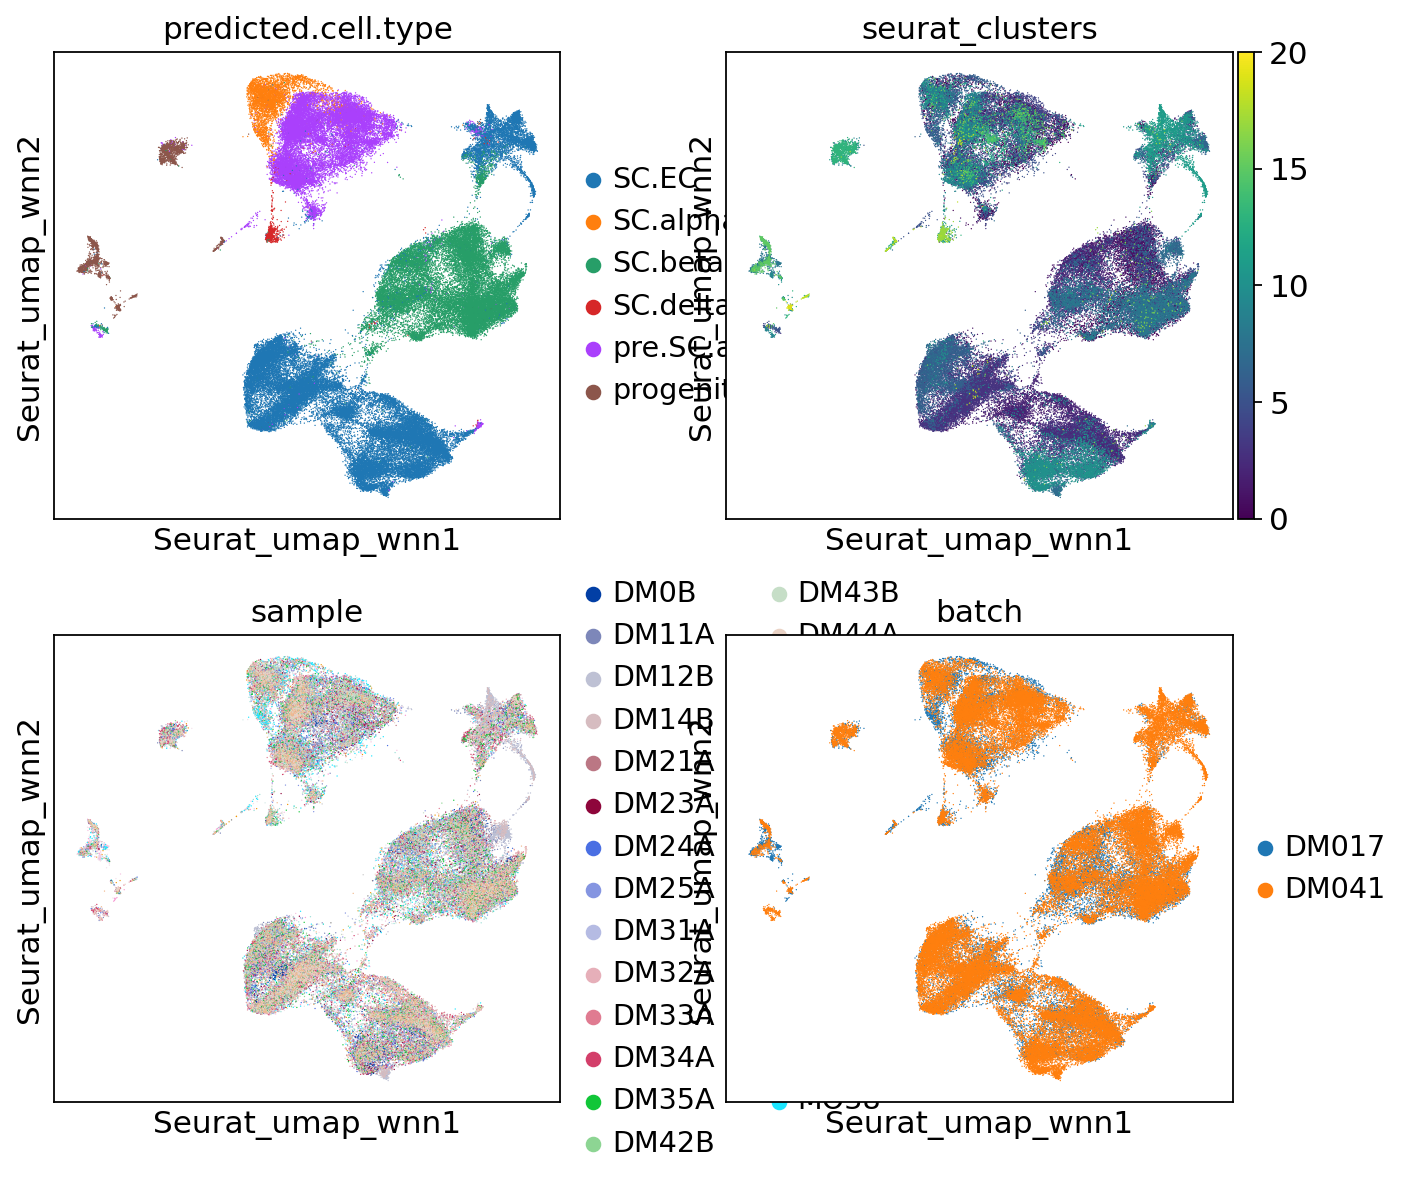

In [24]:
# Check the adata object
sc.pl.embedding(adata, basis='Seurat_umap_wnn', color=['predicted.cell.type', 'seurat_clusters', 'sample', 'batch'], ncols=2)

In [25]:
adata.X[:10, :10].todense()

matrix([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [26]:
# Clean up
adata.obs["seurat_clusters"] = adata.obs["seurat_clusters"].astype("category")
#adata.obs["time_point"] = adata.obs["time_point"].astype("category")

# Prior GRN

In [27]:
net = dc.get_dorothea(organism='human', split_complexes=False)
#net = dc.get_collectri(organism='human', split_complexes=False)
net

,source,confidence,target,weight
0,MYC,A,TERT,1.000000
1,FOS,A,NTS,1.000000
2,FOS,A,NTF3,1.000000
3,FOS,A,NFKB1,-1.000000
4,FOS,A,NEFL,1.000000
...,...,...,...,...
32270,LEF1,C,NKD1,0.333333
32271,LEF1,C,NETO2,0.333333
32272,LEF1,C,MYO18B,0.333333
32273,LEF1,C,PHLDB2,0.333333


In [28]:
net.to_csv(os.path.join(out_dir, "dorothea_network.tsv"), sep="\t")

# Preprocess data

In [16]:
# Basic filtering
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

In [29]:
if normalize_data:
    
    # Normalize the data
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)

    # Store this is raw
    adata.raw = adata

    normalize_data = False

normalizing counts per cell
    finished (0:00:00)


# TF activity inference

In [30]:
dc.run_ulm(
    mat=adata,
    net=net,
    source='source',
    target='target',
    weight='weight',
    use_raw=True,
    verbose=True
)

2820 features of mat are empty, they will be removed.
Running ulm on mat with 83289 samples and 33781 targets for 298 sources.


100%|██████████| 9/9 [00:42<00:00,  4.72s/it]


In [31]:
# These are the t-statistics from the ULM
adata.obsm['ulm_estimate']

,AHR,AR,ARID2,ARID3A,ARNT,ASCL1,ATF1,ATF2,ATF3,ATF4,...,ZNF217,ZNF24,ZNF263,ZNF274,ZNF384,ZNF584,ZNF592,ZNF639,ZNF644,ZNF740
MO1_AAACAGCCAGCAATAA-1,4.597700,6.785600,14.899025,0.911353,12.114625,8.651276,2.896683,6.495327,1.718378,0.110495,...,5.932456,1.029439,10.143121,0.546541,17.160986,-0.786283,0.994200,6.349122,5.141437,3.627630
MO1_AAACCAACAACCGCCA-1,6.410733,6.666407,7.963925,0.782612,13.489685,7.705070,3.375415,5.437353,2.126071,1.193299,...,1.660695,2.225895,10.285474,1.742798,17.139570,-0.766927,-0.311740,3.298493,7.513043,6.447692
MO1_AAACCGCGTATTGTGG-1,6.366870,9.250919,12.863623,-0.318131,12.141128,8.054253,5.237173,3.529350,2.192345,1.512406,...,1.936556,3.538674,13.832656,1.613629,17.356279,0.853609,2.925210,8.102510,7.466889,5.176447
MO1_AAACGCGCAAGCCACT-1,2.076467,5.169741,14.800508,-0.154211,12.548910,10.879133,3.033826,3.966526,3.226131,1.877079,...,3.390865,3.105644,18.640556,0.096972,16.640608,0.019442,1.155664,4.909915,1.043664,6.496734
MO1_AAACGCGCAGTTATCG-1,3.041786,4.304659,8.597121,3.548000,9.470080,8.009967,1.286600,5.702049,2.131366,-0.273153,...,0.353212,-0.203255,10.992730,1.184663,12.294428,-0.653764,-0.864920,0.882799,6.425885,4.313900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DM45_TTTGTCCCAGGCCATT-1,4.871436,4.482881,9.285852,2.878920,7.999893,9.499309,2.059813,5.906188,1.908592,4.479228,...,-0.838100,2.082702,16.867611,2.467167,13.876925,1.861281,1.375576,9.274964,2.947528,6.265357
DM45_TTTGTGAAGGCGCTAC-1,5.557680,3.073339,1.960960,-0.643054,3.897953,2.898381,0.779716,2.596765,-1.731434,-0.315432,...,-0.444594,2.701089,4.907314,1.067287,8.139758,-0.379130,-0.501581,0.685356,8.688000,2.658016
DM45_TTTGTGGCATAATGAG-1,5.491425,5.962459,14.253226,0.477345,9.807228,7.909447,3.677074,4.646336,2.881849,1.505704,...,3.312274,1.321606,12.725197,0.744293,14.299171,0.237855,0.853785,3.929391,5.624416,3.106178
DM45_TTTGTGGCATCGCTCC-1,6.198457,6.721340,9.244415,1.748550,10.267321,9.717672,2.098872,5.847797,3.610432,1.179635,...,2.558315,3.197025,16.114645,0.708114,17.103167,-0.704323,1.702934,3.910011,3.583587,8.214457


In [33]:
# Rename in case we want to try a different model or database
adata.obsm['dorothea_ulm_estimate'] = adata.obsm['ulm_estimate'].copy()
adata.obsm['dorothea_ulm_pvals'] = adata.obsm['ulm_pvals'].copy()
adata

AnnData object with n_obs × n_vars = 83289 × 36601
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'nCount_RNA_raw', 'nFeature_RNA_raw', 'nCount_ATAC', 'nFeature_ATAC', 'nCount_SCT', 'nFeature_SCT', 'SCT.weight', 'ATAC.weight', 'wsnn_res.0.2', 'seurat_clusters', 'log_nCount_ATAC', 'log_nCount_SCT', 'log_nFeature_ATAC', 'log_nFeature_SCT', 'nCount_mpeak', 'nFeature_mpeak', 'batch', 'condition', 'time_point', 'sample', 'atac_raw_reads', 'atac_mitochondrial_reads', 'atac_fragments', 'atac_pct.mt', 'TSS.enrichment', 'TSS.percentile', 'mpeak.weight', 'wsnn_res.0.3', 'cell.type.1', 'cell.type.2', 'predicted.cell.type', 'predicted.cell.type.score'
    var: 'gene_ids', 'feature_types'
    uns: 'predicted.cell.type_colors', 'sample_colors', 'batch_colors', 'log1p'
    obsm: 'Seurat_sct_harmony', 'Seurat_lsi', 'Seurat_harmony', 'Seurat_pca', 'Seurat_atac_harmony', 'Seurat_umap_wnn', 'ulm_estimate', 'ulm_pvals', 'dorothea_ulm_estimate', 'dorothea_ulm_pvals'

# Viz

In [34]:
acts = dc.get_acts(adata, obsm_key='ulm_estimate')

# We can scale the obtained activities for better visualizations
sc.pp.scale(acts)
acts

AnnData object with n_obs × n_vars = 83289 × 298
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'nCount_RNA_raw', 'nFeature_RNA_raw', 'nCount_ATAC', 'nFeature_ATAC', 'nCount_SCT', 'nFeature_SCT', 'SCT.weight', 'ATAC.weight', 'wsnn_res.0.2', 'seurat_clusters', 'log_nCount_ATAC', 'log_nCount_SCT', 'log_nFeature_ATAC', 'log_nFeature_SCT', 'nCount_mpeak', 'nFeature_mpeak', 'batch', 'condition', 'time_point', 'sample', 'atac_raw_reads', 'atac_mitochondrial_reads', 'atac_fragments', 'atac_pct.mt', 'TSS.enrichment', 'TSS.percentile', 'mpeak.weight', 'wsnn_res.0.3', 'cell.type.1', 'cell.type.2', 'predicted.cell.type', 'predicted.cell.type.score'
    var: 'mean', 'std'
    uns: 'predicted.cell.type_colors', 'sample_colors', 'batch_colors', 'log1p'
    obsm: 'Seurat_sct_harmony', 'Seurat_lsi', 'Seurat_harmony', 'Seurat_pca', 'Seurat_atac_harmony', 'Seurat_umap_wnn', 'ulm_estimate', 'ulm_pvals', 'dorothea_ulm_estimate', 'dorothea_ulm_pvals'

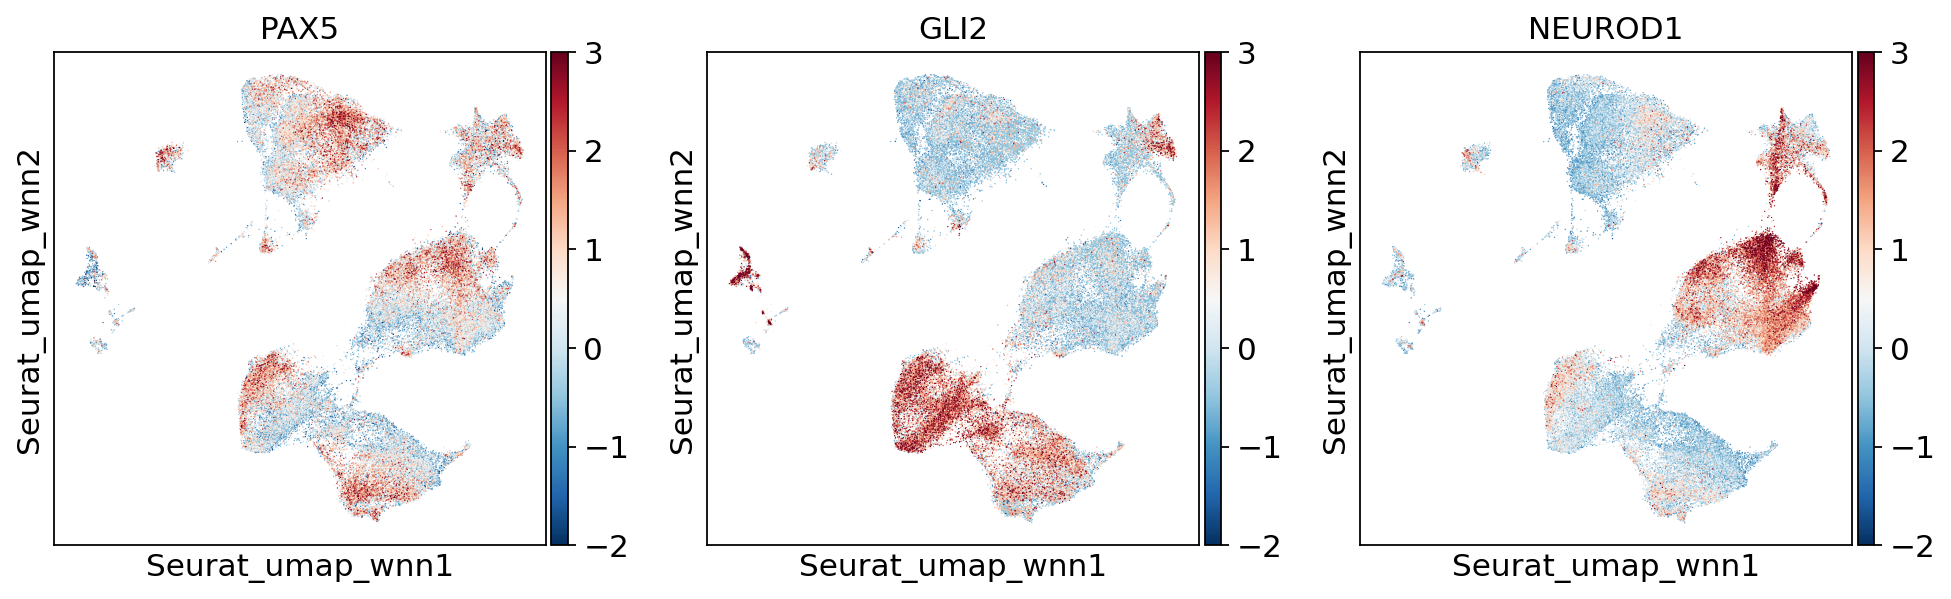

In [62]:
# Plot a few familiar cell types
with plt.rc_context():
    sc.pl.embedding(acts, basis="Seurat_umap_wnn", color=['PAX5', 'GLI2', 'NEUROD1'], cmap='RdBu_r', vmin=-2, vmax=3, show=False)
    plt.savefig(os.path.join(out_dir, "selected_cell_type_annotation_umap.png"))
    plt.show()
    plt.close()


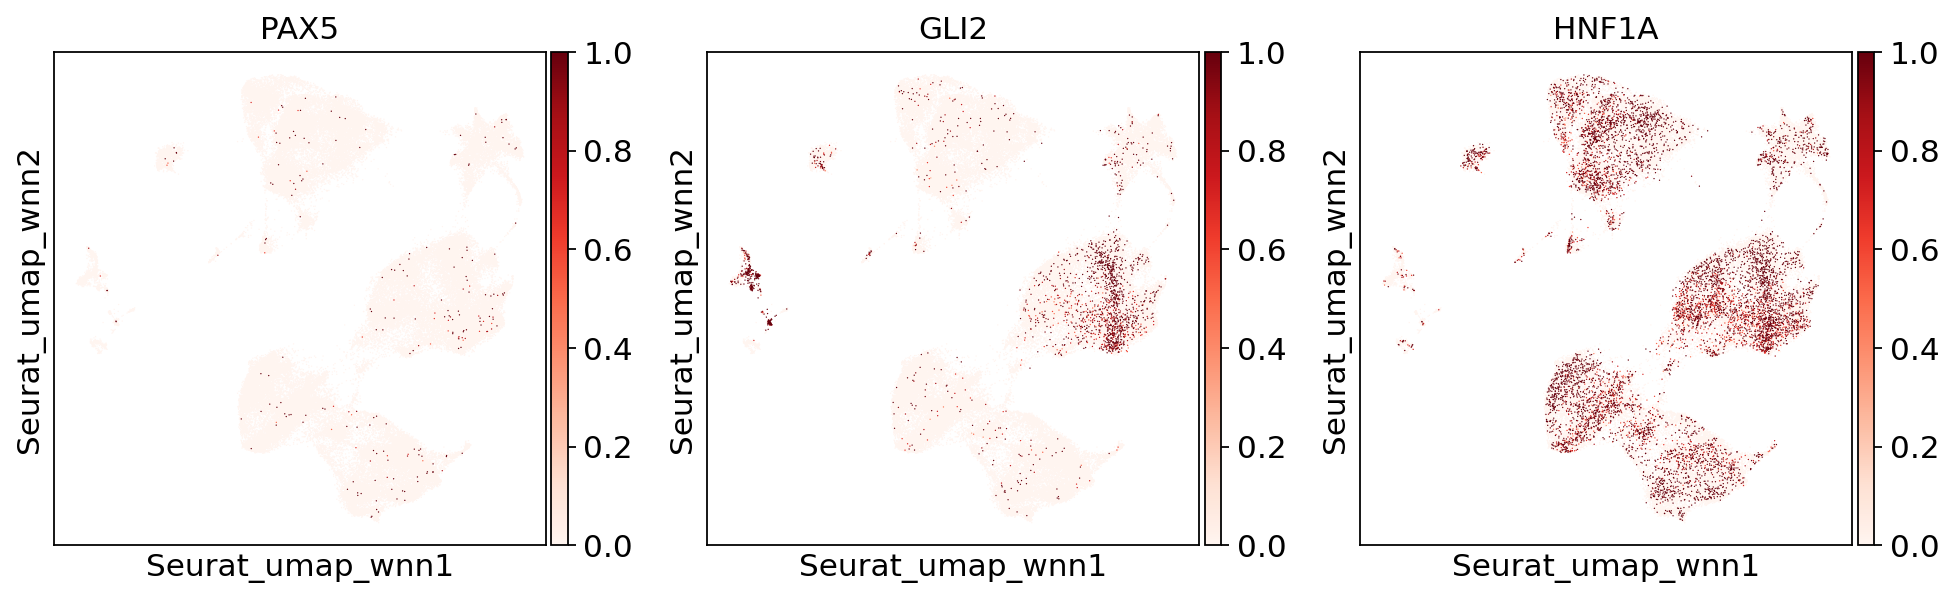

In [59]:
sc.pl.embedding(adata, basis="Seurat_umap_wnn", color=['PAX5', 'GLI2', 'HNF1A'], cmap='Reds', vmin=-0, vmax=1, use_raw=True)

[<Axes: ylabel='PAX5'>, <Axes: ylabel='GLI2'>]

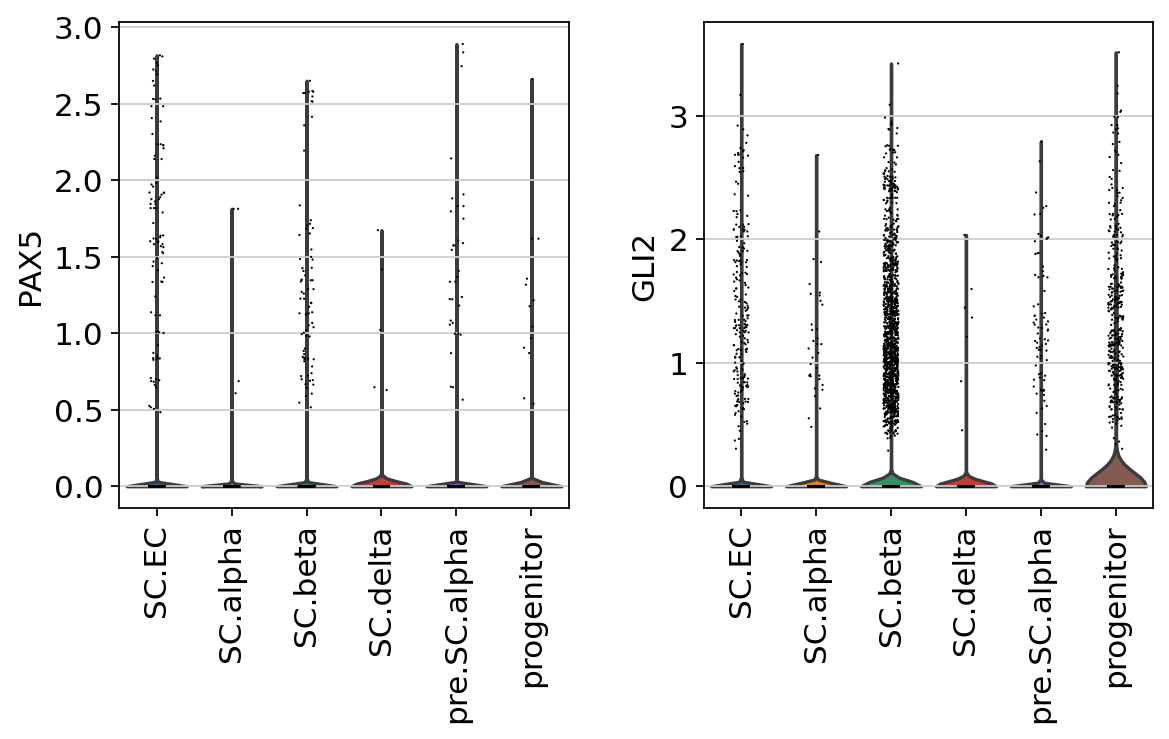

In [52]:
sc.pl.violin(adata, keys=['PAX5', "GLI2"], groupby='predicted.cell.type', multi_panel=True, rotation=90, show=False)

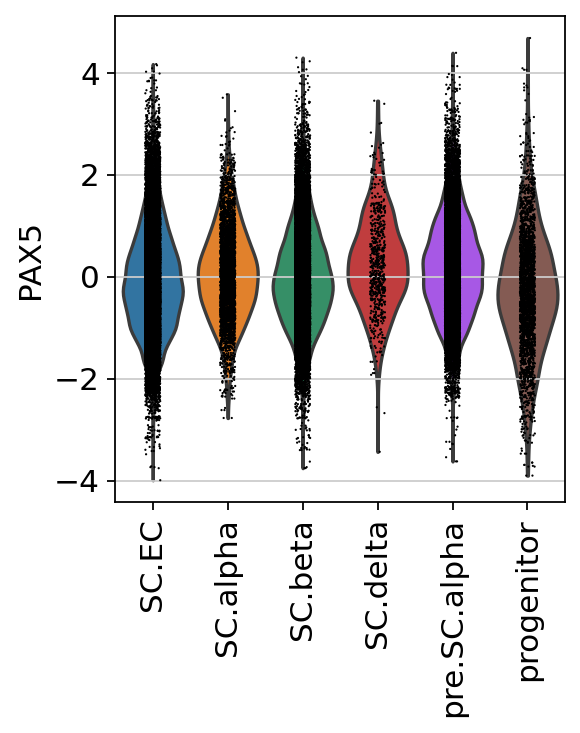

In [39]:
# Plot the violin plots
with plt.rc_context():
    sc.pl.violin(acts, keys=['PAX5'], groupby='predicted.cell.type', multi_panel=True, rotation=90, show=False)
    plt.savefig(os.path.join(out_dir, "selected_cell_type_annotation_violin.png"))
    plt.show()
    plt.close()

# Exploration

In [40]:
df = dc.rank_sources_groups(acts, groupby='predicted.cell.type', reference='rest', method='t-test_overestim_var')
df

,group,reference,names,statistic,meanchange,pvals,pvals_adj
0,SC.EC,rest,GLI2,126.650506,0.889501,0.000000e+00,0.000000e+00
1,SC.EC,rest,JUN,46.095901,0.342973,0.000000e+00,0.000000e+00
2,SC.EC,rest,NFKB2,41.850227,0.313138,0.000000e+00,0.000000e+00
3,SC.EC,rest,MAZ,41.098088,0.309614,0.000000e+00,0.000000e+00
4,SC.EC,rest,LHX4,40.405220,0.303971,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...
1783,progenitor,rest,MAF,-16.618093,-0.449411,1.579785e-60,5.289618e-60
1784,progenitor,rest,LYL1,-17.755760,-0.465258,1.341464e-68,4.935264e-68
1785,progenitor,rest,HSF1,-18.662559,-0.500559,2.191827e-75,9.199499e-75
1786,progenitor,rest,HNF1A,-33.226218,-0.810362,1.519408e-219,4.527834e-218


In [41]:
# Save the annotation results
df.to_csv(os.path.join(out_dir, "dorothea_annotation_results.tsv"), sep="\t")

In [53]:
n_markers = 10
source_markers = df.groupby('group').head(n_markers).groupby('group')['names'].apply(lambda x: list(x)).to_dict()
source_markers

{'SC.EC': ['GLI2',
  'JUN',
  'NFKB2',
  'MAZ',
  'LHX4',
  'MAX',
  'ETS2',
  'ZBTB7A',
  'MBD2',
  'REST'],
 'SC.alpha': ['FOXA2',
  'TCF12',
  'ELF3',
  'TCF7L2',
  'GATA6',
  'PAX6',
  'XBP1',
  'TCF4',
  'MEIS2',
  'STAT5B'],
 'SC.beta': ['NEUROD1',
  'HNF1A',
  'PDX1',
  'CREB1',
  'ATF2',
  'MAFF',
  'BHLHE22',
  'MEIS1',
  'MAFG',
  'HOXB7'],
 'SC.delta': ['POU5F1',
  'TCF7L2',
  'XBP1',
  'MYBL2',
  'RUNX2',
  'POU4F2',
  'MAFB',
  'KMT2A',
  'STAT5B',
  'MEIS2'],
 'pre.SC.alpha': ['RXRG',
  'XBP1',
  'RXRB',
  'HNF4G',
  'ELF3',
  'MAF',
  'CEBPB',
  'TCF7L1',
  'ZNF384',
  'FOXA2'],
 'progenitor': ['E2F4',
  'E2F1',
  'FOXM1',
  'TCF7',
  'ZEB2',
  'SMAD1',
  'TFDP1',
  'MYBL2',
  'CEBPG',
  'MEIS2']}

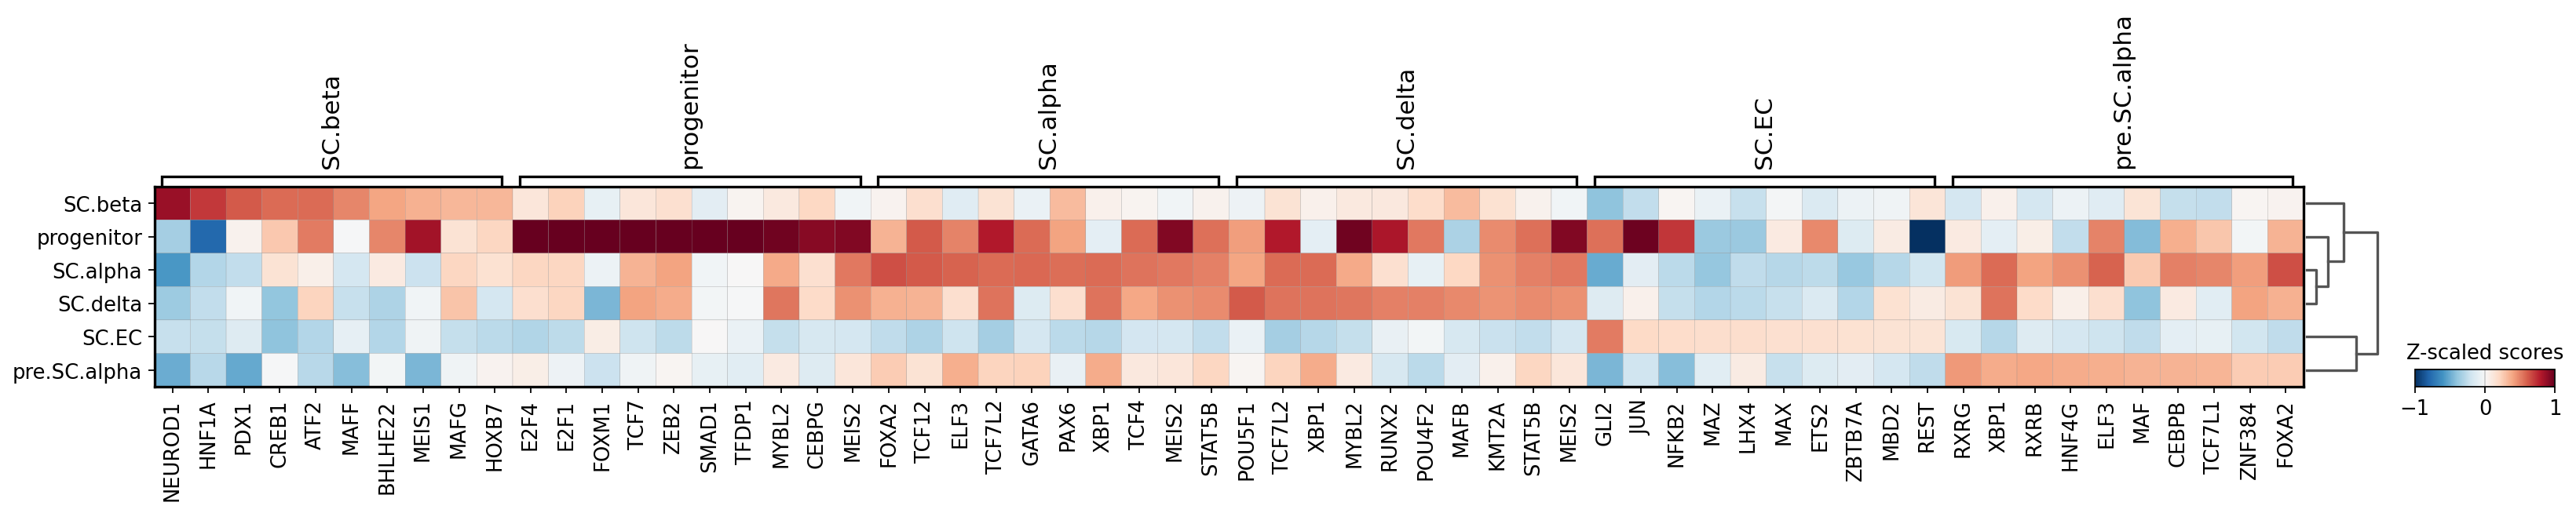

<Figure size 320x320 with 0 Axes>

In [55]:
# And plot that as a matrixplot
with plt.rc_context():
    sc.pl.matrixplot(acts, source_markers, 'predicted.cell.type', dendrogram=True,
                 colorbar_title='Z-scaled scores', vmin=-1, vmax=1, cmap='RdBu_r')
    plt.savefig(os.path.join(out_dir, f"{n_markers}_dorothea_annotation_matrixplot.png"))
    plt.show()

# DONE!

---